# Anàlisi d'estabilitat de dades temporals en models de Simulació d'Esdeveniments Discrets

## Exemple: dades de les recollides de clients en el sistema de taxi (Yellow cab) de Nova York

En aquest exemple s'analitza el comportament del temps entre el temps entre la recollida de clients
en el sistema de taxis de Nova York. Per nosaltres en un model de simulació d'esdeveniments discrets
això seria equivalent al temps entre arribades de clients al sistema. Els taxis de Nova York deixen
públiques les seves dades i es poden consultar i analitzar. En aquest estudi s'analitza l'estabilitat
temporal de les dades i es veu si aquestes estan idènticament distribuïdes per tot el període d'estudi.

Per fer aquesta anàlisi es divideix en la següent seqüència d'accions:

- Importar les dades amb *pandas*
- Filtrar les dades per dos dies (per reduir-ne el volum) i calcular el temps entre arribades.
- Càlcul del nombre d'arribades per segon, acumulat i per probabilitat (per poder mostrar la gràfica p-p).
- Mostrar la gràfica p-p.
- Mostrar un gràfic de barres de les arribades horàries

In [12]:
# Import the necessary libraries from the beginning
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [4]:
# Load the Yellow Cab NYC taxi data
df = pd.read_csv("yellow-tripdata-2025-01.csv", usecols=["tpep_pickup_datetime"])
df.rename(columns={'tpep_pickup_datetime': 'arrival_time'}, inplace=True)
df['arrival_time'] = pd.to_datetime(df['arrival_time'])
# Filter for 14th and 15th of January just to reduce the data set length
from_ts = datetime.datetime(2025,1,14,0,0,0)
to_ts = datetime.datetime(2025,1,16,0,0,0)
df = df[(from_ts <= df['arrival_time']) & ( df['arrival_time'] < to_ts)]
# Compute interarrival time
df.sort_values('arrival_time', inplace=True)
df['interarrival'] = df['arrival_time'].diff().dt.total_seconds()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,arrival_time,interarrival
0,2025-01-14 00:00:02,1.0
1,2025-01-14 00:00:02,0.0
2,2025-01-14 00:00:04,2.0
3,2025-01-14 00:00:19,15.0
4,2025-01-14 00:00:26,7.0


In [5]:
# Create the data needed to show a p-p graph
# Count arrivals for each second in both days
counts = df['arrival_time'].value_counts().sort_index()
counts_df = counts.reset_index()
counts_df.columns = ['date', 'count']
counts_df['date'] = pd.to_datetime(counts_df['date'])
# Create a data frame with each second and the arrival count in that second
number_of_seconds = 24 * 60 * 60 * 2
pp_df = pd.DataFrame()
pp_df['second'] = range(0, number_of_seconds)
pp_df['arrivals_count'] = 0
for index, row in counts_df.iterrows():
    second = row['date'].hour * 3600 + row['date'].minute * 60 + row['date'].second + 86400 * (row['date'].day - 14)
    pp_df.loc[second, 'arrivals_count'] = row['count']
# Compute cumulative values
pp_df['cumulative_arrivals'] = pp_df['arrivals_count'].cumsum()
# Compute proportions for the p-p graph
pp_df['pp_x'] = pp_df['second'] / pp_df['second'].max()
pp_df['pp_y'] = pp_df['cumulative_arrivals'] / pp_df['cumulative_arrivals'].max()
print(pp_df)

        second  arrivals_count  cumulative_arrivals      pp_x      pp_y
0            0               0                    0  0.000000  0.000000
1            1               0                    0  0.000006  0.000000
2            2               2                    2  0.000012  0.000008
3            3               0                    2  0.000017  0.000008
4            4               1                    3  0.000023  0.000012
...        ...             ...                  ...       ...       ...
172795  172795               0               247090  0.999977  0.999988
172796  172796               1               247091  0.999983  0.999992
172797  172797               1               247092  0.999988  0.999996
172798  172798               1               247093  0.999994  1.000000
172799  172799               0               247093  1.000000  1.000000

[172800 rows x 5 columns]


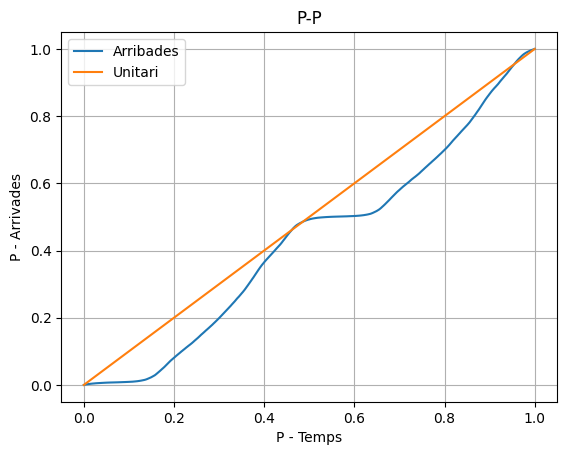

In [11]:
# Show the p-p graph
plt.plot(pp_df['pp_x'], pp_df['pp_y'], label='Arribades')
plt.plot([0, 1], [0, 1], label='Unitari')
plt.title("P-P")
plt.xlabel('P - Temps')
plt.ylabel('P - Arrivades')
plt.legend()
plt.grid()
plt.show()

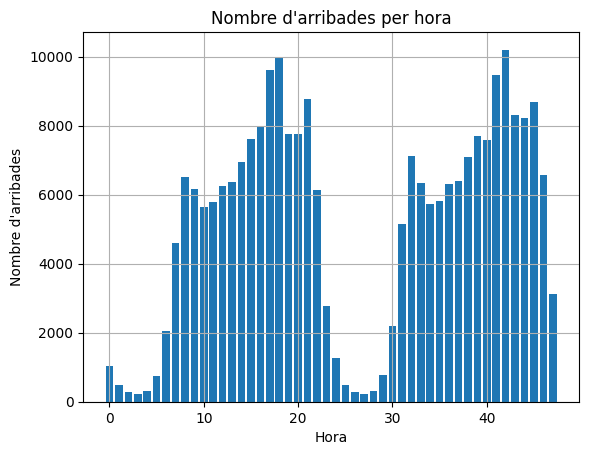

In [10]:
# Create an hourly number of arrivals data frame
pp_df['hour'] = pp_df['second'] // 3600
hour_df = pp_df.groupby('hour').sum()
hour_df = hour_df['arrivals_count']
plt.bar(hour_df.index, hour_df)
plt.title("Nombre d'arribades per hora")
plt.xlabel('Hora')
plt.ylabel("Nombre d'arribades")
plt.grid()

# Anàlisi dels resultats obtinguts

Observant les dades graficades es pot veure clarament que tant les peticions horàries de taxis (diagrama de barres) com amb
la gràfica p-p (probabilitats) les peticions de taxi no estan idènticament distribuïdes.

En el gràfic p-p s'aprecia que no segueix la proporcionalitat 1:1, durant la nit hi ha poques arribades (pendent < 1)
i a mesura que el dia avança les arribades creixen (pendent > 1). Amb la gràfica de barres s'aprecia el mateix comportament.

També es pot fer un test d'Estacionarietat: Augmented Dickey–Fuller test

Podeu aprendre'n més a:

- [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)
- [Arrel unitària](https://en.wikipedia.org/wiki/Unit_root)
- [Procés estacionari](https://en.wikipedia.org/wiki/Stationary_process)

In [13]:
# Compute the ADF Test
result = adfuller(df['interarrival'])
# Show the results
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -8.044126375699745
p-value: 1.8137137179138182e-12


Trobar un conjunt de dades reals amb temps d'arribada estacionaris pot ser complicat perquè la majoria dels sistemes reals
(com dades de trànsit, urgències hospitalàries, transaccions bancàries, etc.) presenten un comportament no estacionari a
causa dels efectes del mateix comportament humà.

## i l'estabilitat de la duració? El trajecte depèn també de l'hora?

In [26]:
df = pd.read_csv("yellow-tripdata-2025-01.csv", usecols=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
df.rename(columns={'tpep_pickup_datetime': 'arrival_time'}, inplace=True)
df.rename(columns={'tpep_dropoff_datetime': 'finish_time'}, inplace=True)
df['arrival_time'] = pd.to_datetime(df['arrival_time'])
df['finish_time'] = pd.to_datetime(df['finish_time'])
# Filter for 14th and 15th of January just to reduce the data set length
from_ts = datetime.datetime(2025,1,14,0,0,0)
to_ts = datetime.datetime(2025,1,15,0,0,0)
df = df[(from_ts <= df['arrival_time']) & ( df['arrival_time'] < to_ts)]
df['hour'] = df['arrival_time'].dt.hour
df['length'] = (df['finish_time'] - df['arrival_time']).dt.total_seconds()

df.head()

,arrival_time,finish_time,hour,length
109889,2025-01-14 00:01:11,2025-01-14 00:05:19,0,248.0
110076,2025-01-14 00:11:26,2025-01-15 00:10:21,0,86335.0
110462,2025-01-14 00:12:15,2025-01-14 00:20:10,0,475.0
110463,2025-01-14 00:47:18,2025-01-14 00:52:59,0,341.0
110464,2025-01-14 00:42:08,2025-01-14 01:02:53,0,1245.0


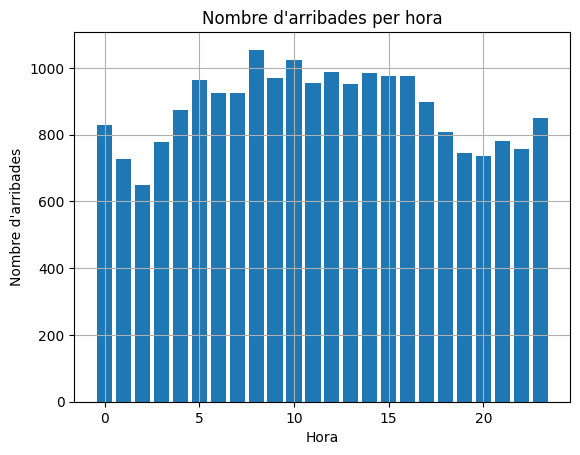

In [30]:
hour_df = df.groupby('hour').mean()
# Create an hourly number of arrivals data frame
plt.bar(hour_df.index, hour_df['length'])
plt.title("Duració del trajecte per hora")
plt.xlabel('Hora')
plt.ylabel("Nombre d'arribades")
plt.grid()

In [56]:
import scipy.stats as ss
samples = [hour[1] for hour in df.groupby('hour')['length']]
f_val, p_val = ss.f_oneway(*samples[11:17])
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))
f_val, p_val = ss.f_oneway(*samples[8:11])
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))
f_val, p_val = ss.f_oneway(*samples[5:8])
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))
f_val, p_val = ss.f_oneway(*samples[19:23])
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

result = ss.tukey_hsd(*samples)
print(result)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['length'],
                          groups=df['hour'],
                          alpha=0.05)

#display results
print(tukey)

F value: 0.727, p value: 0.603
F value: 2.815, p value: 0.060
F value: 0.639, p value: 0.528
F value: 2.052, p value: 0.104
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    101.531     1.000  -197.438   400.501
 (0 - 2)    177.914     0.983  -180.032   535.860
 (0 - 3)     50.619     1.000  -359.242   460.480
 (0 - 4)    -45.451     1.000  -400.601   309.700
 (0 - 5)   -135.630     0.971  -396.830   125.569
 (0 - 6)    -95.734     0.993  -302.629   111.162
 (0 - 7)    -95.901     0.975  -282.608    90.806
 (0 - 8)   -226.179     0.001  -407.770   -44.587
 (0 - 9)   -142.950     0.397  -325.258    39.358
 (0 - 10)   -195.581     0.021  -379.034   -12.128
 (0 - 11)   -125.733     0.678  -308.834    57.369
 (0 - 12)   -160.291     0.182  -342.369    21.787
 (0 - 13)   -123.567     0.698  -305.419    58.285
 (0 - 14)   -157.789     0.195  -338.599    23.020
 (0 - 15)   -147.583     0.303  -327.359    32.194
 (